In [540]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from datetime import datetime
from math import sqrt

from scipy.stats import linregress
from numpy import array

In [541]:
df = pd.read_excel('Dados.xlsx')

In [542]:
df['ANOMES'] = pd.to_datetime(df['ANOMES'], format="%d/%m/%Y")
df['USD_2_BRL_Variation']=(df['Câmbio'].astype(float)).pct_change()
df['SELIC'] = df['SELIC']*100
df['fator_selic'] = 1+(df['SELIC'].astype(float))/100

In [543]:
#BASE INFLAÇÃO
df_inf = df.copy()
df_inf['fator'] = 1+(df['IPCA'].astype(float))/100

df_inf['fator_acumulado']=1.000000
df_inf['fator_acumulado'][0]=df_inf['fator'][0]
for i in range(1, len(df)):
    df_inf['fator_acumulado'][i] = df_inf['fator'][i]*df_inf['fator_acumulado'][i-1]
df_inf['Inflacao_12_Meses']=(df_inf['fator_acumulado']/df_inf['fator_acumulado'].shift(12)-1)*100

df_inf['Inflacao_12_Meses_Shift']=df_inf['Inflacao_12_Meses'].shift(-12)

C:\Users\chris\AppData\Local\Temp\ipykernel_21088\497968519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['fator_acumulado'][0]=df_inf['fator'][0]
C:\Users\chris\AppData\Local\Temp\ipykernel_21088\497968519.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['fator_acumulado'][i] = df_inf['fator'][i]*df_inf['fator_acumulado'][i-1]


In [544]:
df_inf['PIM'] = df_inf['PIM'].fillna(0)

In [545]:
#BASE SELIC
df_selic = df.copy()
df_selic['SELIC'] = df_selic['SELIC']
df_selic['fator_selic'] = 1+(df_selic['SELIC'].astype(float))/100
df_selic['acumulado_selic']=1.000000
df_selic['acumulado_selic'][0]=df_selic['fator_selic'][0]
for i in range(1, len(df)):
    df_selic['acumulado_selic'][i] = df_selic['fator_selic'][i]*df_selic['acumulado_selic'][i-1]
    
df_selic['Selic_12_Meses']=(df_selic['acumulado_selic']/df_selic['acumulado_selic'].shift(12)-1)*100

df_selic['Selic_12_Meses_Shift']=df_selic['Selic_12_Meses'].shift(-12)

C:\Users\chris\AppData\Local\Temp\ipykernel_21088\199141671.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selic['acumulado_selic'][0]=df_selic['fator_selic'][0]
C:\Users\chris\AppData\Local\Temp\ipykernel_21088\199141671.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selic['acumulado_selic'][i] = df_selic['fator_selic'][i]*df_selic['acumulado_selic'][i-1]


In [546]:
#BASE PIM
df_pim = df.copy()
df_pim = df_pim.dropna().reset_index(drop=True)
df_pim['acumulado_pim']=0
df_pim['acumulado_pim'][0]=df_pim['PIM'][0]
for i in range(1, len(df_pim)):
    df_pim['acumulado_pim'][i] = df_pim['PIM'][i]+df_pim['acumulado_pim'][i-1]
df_pim['pim_12_Meses']=(df_pim['acumulado_pim']-df_pim['acumulado_pim'].shift(12)-1)
df_pim['Pim_12_Meses_Shift']=df_pim['pim_12_Meses'].shift(-12)

C:\Users\chris\AppData\Local\Temp\ipykernel_21088\4052781958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pim['acumulado_pim'][0]=df_pim['PIM'][0]
C:\Users\chris\AppData\Local\Temp\ipykernel_21088\4052781958.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pim['acumulado_pim'][i] = df_pim['PIM'][i]+df_pim['acumulado_pim'][i-1]


In [547]:
#INFLAÇÃO

X=df_inf.dropna(how='any')[['IPCA', 'fator_selic','USD_2_BRL_Variation','Inflacao_12_Meses', 'PIM']]
Y=df_inf.dropna(how='any')['Inflacao_12_Meses_Shift']

for column in X.columns:
        x=np.array(X[column],dtype=np.float32)
        y=np.array(Y,dtype=np.float32)
        slope, Intercept, r_value, p_value, std_err = linregress(x,y)
        print('Analysis for: ' + column +' vs Future Inflation:')
        print('p_value: '+str(p_value))
        print('R-Squared: '+str(r_value**2))

Analysis for: IPCA vs Future Inflation:
p_value: 5.048091038026004e-20
R-Squared: 0.22796744894873763
Analysis for: fator_selic vs Future Inflation:
p_value: 1.5688958689336216e-10
R-Squared: 0.1185300957809344
Analysis for: USD_2_BRL_Variation vs Future Inflation:
p_value: 0.9058682987483051
R-Squared: 4.309129448034037e-05
Analysis for: Inflacao_12_Meses vs Future Inflation:
p_value: 7.028028356780002e-21
R-Squared: 0.23718756252737888
Analysis for: PIM vs Future Inflation:
p_value: 0.0005114525982611389
R-Squared: 0.036522421855159796


In [548]:
df['ANOMES'][int(df.shape[0]*0.7)]

Timestamp('2014-06-01 00:00:00')

In [549]:
df_inf=df_inf.dropna(subset=['IPCA', 'SELIC','USD_2_BRL_Variation','Inflacao_12_Meses', 'PIM','Inflacao_12_Meses_Shift']).reset_index(drop=True)

In [550]:
#model construction
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [551]:
n_steps=12
n_features=X.values.shape[1]

In [552]:
n_neurons_dense=64
dropout_ratio=0.3
model=Sequential()
model.add(LSTM(100,dropout=dropout_ratio,recurrent_dropout=dropout_ratio,input_shape=(n_steps,n_features)))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_neurons_dense,activation='tanh'))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_neurons_dense/2,activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_neurons_dense/(2**2),activation='softmax'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1,activation='linear'))

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.008))

In [553]:
def split_sequence(df,Y,n_steps):
  columns=list(df.columns)
  X, y = list(), list()
  for i in range(len(df)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(df)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = df[columns][i:end_ix].values, Y[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y).reshape(-1,1)

In [554]:
X,Y=split_sequence(df_inf[['IPCA', 'SELIC','USD_2_BRL_Variation','Inflacao_12_Meses', 'PIM']],
                   df_inf['Inflacao_12_Meses_Shift'],n_steps)

In [555]:
print("X Shape: "+str(X.shape))
print("Y Shape: "+str(Y.shape))   

X Shape: (315, 12, 5)
Y Shape: (315, 1)


In [556]:
X_train=X[:int(df_inf.shape[0]*0.7),:,:]
X_test=X[-(len(X)-int(df_inf.shape[0]*0.7)):,:,:]
Y_Train=Y[:int(df_inf.shape[0]*0.7)]
Y_Test=Y[-(len(X)-int(df_inf.shape[0]*0.7)):]

In [557]:
print(X_train.shape)
print(X_test.shape)

(228, 12, 5)
(87, 12, 5)


In [558]:
print(Y_Train.shape)
print(Y_Test.shape)

(228, 1)
(87, 1)


In [559]:
a = model.fit(X_train.astype(np.float32), Y_Train.astype(np.float32), epochs=350, verbose=1, validation_split=0.2)

Epoch 1/350
6/6 [==============================] - 3s 63ms/step - loss: 44.9310 - val_loss: 40.7885
Epoch 2/350
6/6 [==============================] - 0s 12ms/step - loss: 41.4114 - val_loss: 38.6204
Epoch 3/350
6/6 [==============================] - 0s 12ms/step - loss: 39.5307 - val_loss: 37.2769
Epoch 4/350
6/6 [==============================] - 0s 12ms/step - loss: 38.4051 - val_loss: 36.0520
Epoch 5/350
6/6 [==============================] - 0s 13ms/step - loss: 37.4351 - val_loss: 34.8674
Epoch 6/350
6/6 [==============================] - 0s 12ms/step - loss: 37.5629 - val_loss: 33.7203
Epoch 7/350
6/6 [==============================] - 0s 12ms/step - loss: 35.3029 - val_loss: 32.6045
Epoch 8/350
6/6 [==============================] - 0s 12ms/step - loss: 34.0028 - val_loss: 31.5197
Epoch 9/350
6/6 [==============================] - 0s 12ms/step - loss: 34.3528 - val_loss: 30.4793
Epoch 10/350
6/6 [==============================] - 0s 12ms/step - loss: 33.3016 - val_loss: 29.4771

6/6 [==============================] - 0s 13ms/step - loss: 11.5329 - val_loss: 4.4860
Epoch 83/350
6/6 [==============================] - 0s 13ms/step - loss: 12.5871 - val_loss: 4.4261
Epoch 84/350
6/6 [==============================] - 0s 13ms/step - loss: 13.1914 - val_loss: 4.3884
Epoch 85/350
6/6 [==============================] - 0s 13ms/step - loss: 13.4308 - val_loss: 4.3466
Epoch 86/350
6/6 [==============================] - 0s 12ms/step - loss: 12.4890 - val_loss: 4.2969
Epoch 87/350
6/6 [==============================] - 0s 12ms/step - loss: 12.9392 - val_loss: 4.2423
Epoch 88/350
6/6 [==============================] - 0s 13ms/step - loss: 12.4253 - val_loss: 4.2016
Epoch 89/350
6/6 [==============================] - 0s 12ms/step - loss: 12.1210 - val_loss: 4.1629
Epoch 90/350
6/6 [==============================] - 0s 13ms/step - loss: 12.0397 - val_loss: 4.1333
Epoch 91/350
6/6 [==============================] - 0s 14ms/step - loss: 13.0489 - val_loss: 4.1111
Epoch 92/350


6/6 [==============================] - 0s 12ms/step - loss: 10.9856 - val_loss: 3.1103
Epoch 164/350
6/6 [==============================] - 0s 12ms/step - loss: 10.3352 - val_loss: 3.1117
Epoch 165/350
6/6 [==============================] - 0s 12ms/step - loss: 10.3057 - val_loss: 3.1117
Epoch 166/350
6/6 [==============================] - 0s 12ms/step - loss: 10.5872 - val_loss: 3.1127
Epoch 167/350
6/6 [==============================] - 0s 12ms/step - loss: 11.0032 - val_loss: 3.1149
Epoch 168/350
6/6 [==============================] - 0s 13ms/step - loss: 9.7856 - val_loss: 3.1142
Epoch 169/350
6/6 [==============================] - 0s 12ms/step - loss: 10.5400 - val_loss: 3.1163
Epoch 170/350
6/6 [==============================] - 0s 13ms/step - loss: 10.1189 - val_loss: 3.1133
Epoch 171/350
6/6 [==============================] - 0s 13ms/step - loss: 10.5647 - val_loss: 3.1107
Epoch 172/350
6/6 [==============================] - 0s 12ms/step - loss: 10.2508 - val_loss: 3.1071
Epoch

Epoch 245/350
6/6 [==============================] - 0s 12ms/step - loss: 8.6793 - val_loss: 4.5662
Epoch 246/350
6/6 [==============================] - 0s 12ms/step - loss: 8.5701 - val_loss: 4.6242
Epoch 247/350
6/6 [==============================] - 0s 12ms/step - loss: 8.0786 - val_loss: 4.4693
Epoch 248/350
6/6 [==============================] - 0s 12ms/step - loss: 8.7238 - val_loss: 4.2894
Epoch 249/350
6/6 [==============================] - 0s 12ms/step - loss: 8.4932 - val_loss: 4.0869
Epoch 250/350
6/6 [==============================] - 0s 12ms/step - loss: 8.4043 - val_loss: 2.3826
Epoch 251/350
6/6 [==============================] - 0s 11ms/step - loss: 8.5590 - val_loss: 2.3367
Epoch 252/350
6/6 [==============================] - 0s 12ms/step - loss: 8.3148 - val_loss: 2.3403
Epoch 253/350
6/6 [==============================] - 0s 11ms/step - loss: 8.4223 - val_loss: 3.7119
Epoch 254/350
6/6 [==============================] - 0s 12ms/step - loss: 8.9669 - val_loss: 2.4727


Epoch 327/350
6/6 [==============================] - 0s 12ms/step - loss: 6.8256 - val_loss: 3.3271
Epoch 328/350
6/6 [==============================] - 0s 12ms/step - loss: 7.2552 - val_loss: 3.3696
Epoch 329/350
6/6 [==============================] - 0s 12ms/step - loss: 6.8586 - val_loss: 3.3611
Epoch 330/350
6/6 [==============================] - 0s 12ms/step - loss: 7.3377 - val_loss: 3.3682
Epoch 331/350
6/6 [==============================] - 0s 12ms/step - loss: 6.9001 - val_loss: 3.3458
Epoch 332/350
6/6 [==============================] - 0s 12ms/step - loss: 7.5134 - val_loss: 3.3095
Epoch 333/350
6/6 [==============================] - 0s 12ms/step - loss: 6.0923 - val_loss: 3.3183
Epoch 334/350
6/6 [==============================] - 0s 11ms/step - loss: 6.8149 - val_loss: 3.3232
Epoch 335/350
6/6 [==============================] - 0s 11ms/step - loss: 6.8165 - val_loss: 3.2980
Epoch 336/350
6/6 [==============================] - 0s 12ms/step - loss: 6.7221 - val_loss: 3.3022


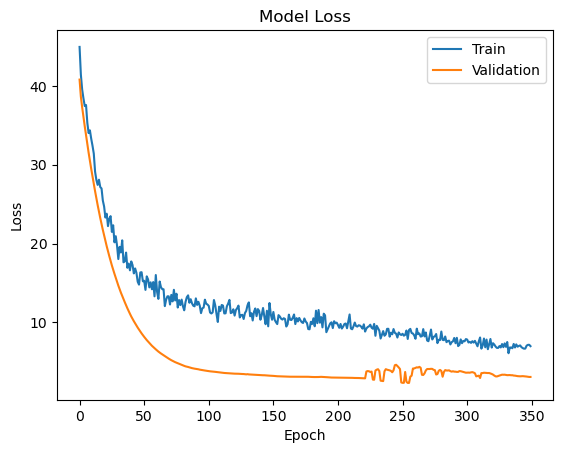

In [560]:
plt.plot(a.history['loss'], label='Train')
plt.plot(a.history['val_loss'], label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')

In [561]:
Y_pred=model.predict(X_test.astype(np.float32))

3/3 [==============================] - 0s 3ms/step


In [562]:
Y_pred[0]

array([5.881034], dtype=float32)

In [563]:
from sklearn.metrics import mean_squared_error

df_result=pd.DataFrame()
df_result['Ground_Truth']=Y_Test.reshape(1,-1)[0]
df_result['NN_Prediction']=Y_pred.reshape(1,-1)[0]
df_result=df_result.dropna(how='any')

#Mean Squared error of neural network prediction:
print("Mean Squared Error of neural network prediction: "+str(mean_squared_error(df_result['Ground_Truth'],df_result['NN_Prediction'])))
print("Mean absolute percentage error: "+str(mean_absolute_percentage_error(df_result['Ground_Truth'],df_result['NN_Prediction'])))
print("Mean absolute error: "+str(mean_absolute_error(df_result['Ground_Truth'],df_result['NN_Prediction'])))


Mean Squared Error of neural network prediction: 8.65112502454447
Mean absolute percentage error: 0.5660910793181418
Mean absolute error: 2.5778426722051226


In [564]:
df_result

,Ground_Truth,NN_Prediction
0,10.706293,5.881034
1,10.356303,5.881034
2,9.386928,5.881034
3,9.278312,5.881034
4,9.321702,5.881034
...,...,...
82,5.900488,5.881034
83,5.784842,5.881034
84,5.774320,5.881034
85,5.596302,5.881034


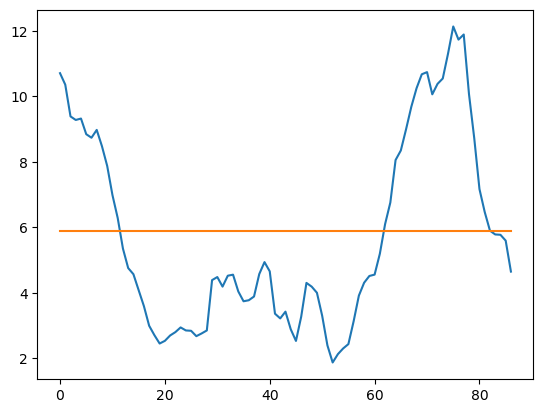

In [565]:
plt.plot(Y_Test)
plt.plot(Y_pred)